In [1]:
import csv
import os
import sys
import tomllib
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from monai.losses import DiceLoss
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.utils import set_determinism

from src.utils import setup_dirs

sys.path.insert(0, "..")

In [2]:
root_dir = Path(os.getcwd()).parent
data_dir, log_dir, root_out_dir = setup_dirs(root_dir)
data_dir = data_dir / "M&MS" / "OpenDataset"

with open(root_dir / "config.toml", "rb") as file:
    config = tomllib.load(file)

pprint(config)
batch_size = config["hyperparameters"].get("batch_size", 4)
epochs = config["hyperparameters"].get("epochs", 100)
learning_rate = config["hyperparameters"].get("learning_rate", 1e-5)
percentage_data = config["hyperparameters"].get("percentage_data", 1.0)
validation_split = config["hyperparameters"].get("validation_split", 0.8)

set_determinism(seed=config["hyperparameters"]["seed"])

{'hyperparameters': {'augment': True,
                     'batch_size': 8,
                     'epochs': 150,
                     'learning_rate': 1e-06,
                     'percentage_data': 1.0,
                     'seed': 42,
                     'spatial_dimensions': 3,
                     'validation_split': 0.8}}


In [13]:
training_dir = data_dir / "Training"
labeled = training_dir / "Labeled"

# Although there are '_gt.nii.gz' files in this 'unlabeled' folder, the segmentations are empty.
unlabeled = training_dir / "Unlabeled"

# Again, although there are '_gt.nii.gz' they are unlabeled?
validation_dir = data_dir / "Validation"
train_patients = [f.name for f in os.scandir(labeled) if f.is_dir()]
val_patients = [f.name for f in os.scandir(data_dir / "Validation") if f.is_dir()]
test_patients = [f.name for f in os.scandir(data_dir / "Testing") if f.is_dir()]

train_patients

['F6J9L9',
 'O7Q7U3',
 'K3R0Y7',
 'E1L8Y4',
 'P8V0Y7',
 'K5K6N1',
 'H6P7T1',
 'G7Q2W0',
 'E3F2U7',
 'C4E9I1',
 'D5G3W8',
 'D6N7Q8',
 'D1R0Y5',
 'D1S5T8',
 'H3R6S9',
 'A5C2D2',
 'C6E0F9',
 'D2U0V0',
 'C5L0R0',
 'K5M7V5',
 'A9F3T5',
 'B0H7V0',
 'D1H6U2',
 'K9N0W0',
 'D7M8P9',
 'I4L4V7',
 'E4O8P3',
 'D7T3V8',
 'C8J7L5',
 'N2O7U5',
 'I7W4Y8',
 'C8I7P7',
 'D8O0W2',
 'J6M5O2']

In [4]:
cardiac_phase_indexes = {}

num_train = 0
num_val = 0
num_test = 0
num_unknown = 0

with open(data_dir / "211230_M&Ms_Dataset_information_diagnosis_opendataset.csv") as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    patient_index = headers.index("External code")
    ed_index = headers.index("ED")
    es_index = headers.index("ES")
    for row in reader:
        # cardiac_phase_indexes[row[patient_index]] = [row[ed_index], row[es_index]]
        patient_label = row[patient_index]
        cardiac_phase_indexes[patient_label] = {
            "end_diastole": int(row[ed_index]),
            "end_systole": int(row[es_index]),
        }

        if patient_label in train_patients:
            num_train += 1
        elif patient_label in val_patients:
            num_val += 1
        elif patient_label in test_patients:
            num_test += 1
        else:
            num_unknown += 1

print(f"Train: {num_train}\nVal: {num_val}\nTest: {num_test}\nUnknown: {num_unknown}")
print(f"Total: {num_train + num_val + num_test + num_unknown}")

Train: 150
Val: 34
Test: 136
Unknown: 25
Total: 345


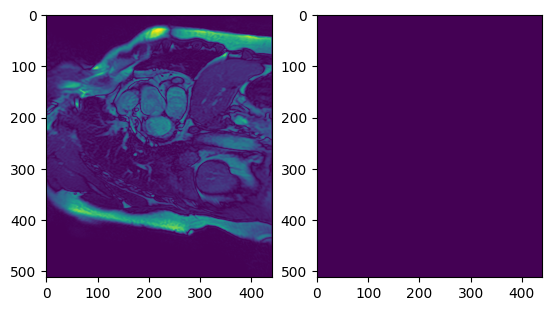

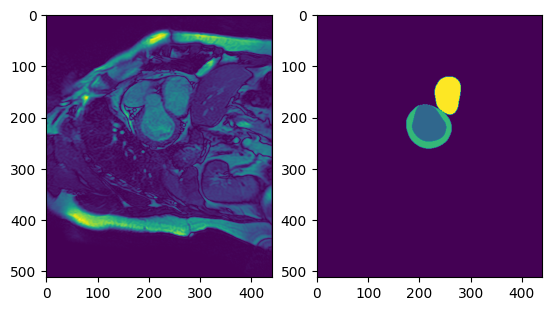

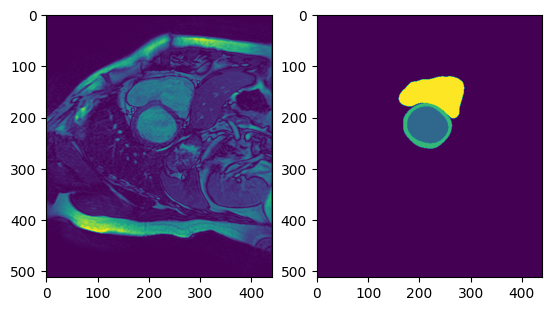

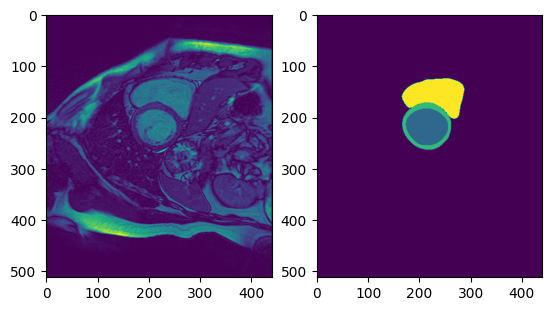

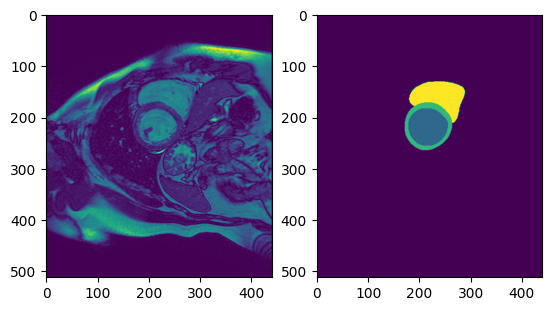

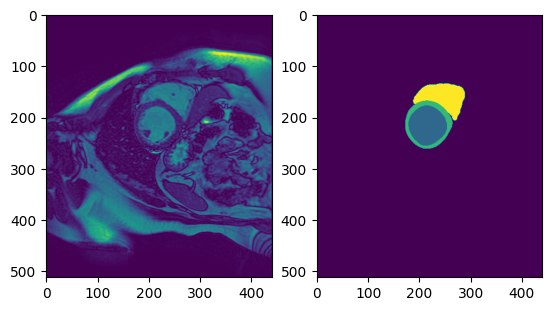

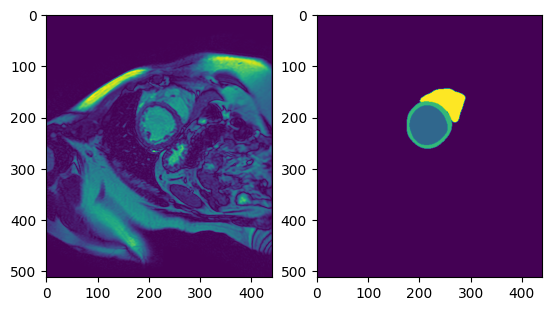

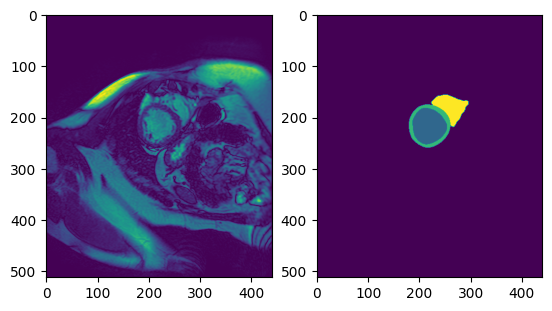

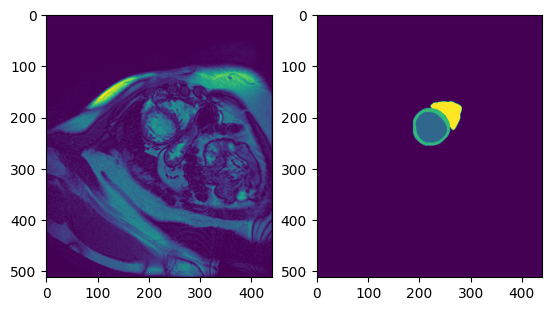

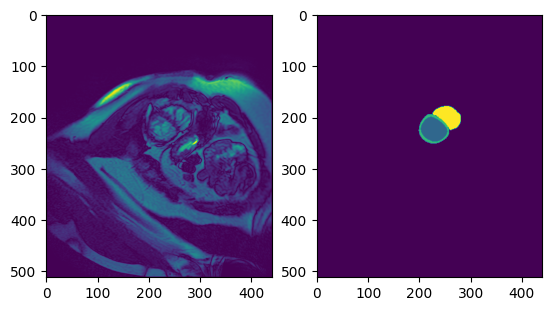

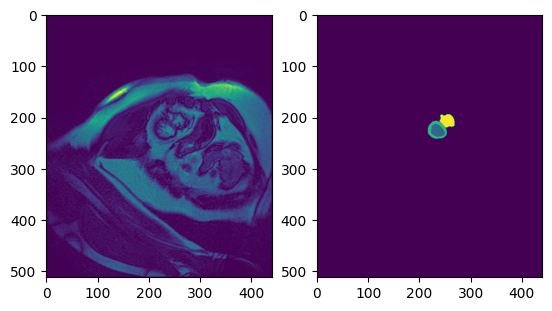

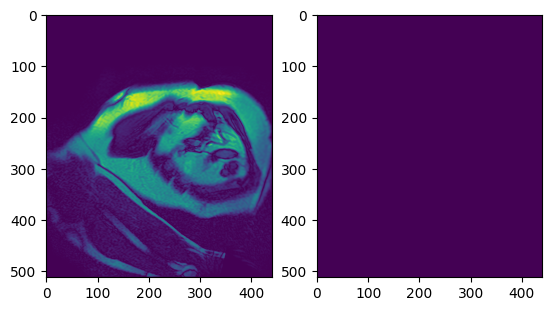

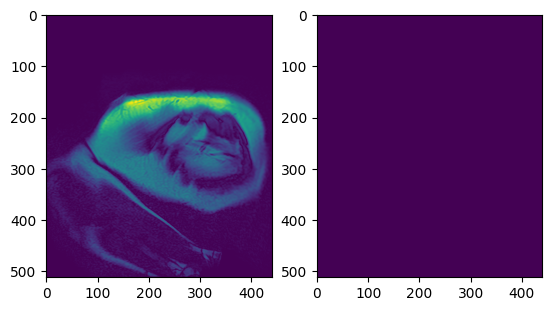

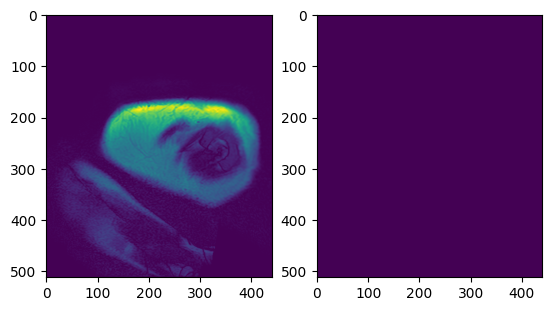

In [16]:
patient = labeled / train_patients[0]
image = nib.load(patient / f"{patient.name}_sa.nii.gz")
label = nib.load(patient / f"{patient.name}_sa_gt.nii.gz")

image = image.get_fdata(dtype=np.float32)
label = label.get_fdata(dtype=np.float32)

_, _, slices, times = image.shape
for i in range(slices):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image[..., i, cardiac_phase_indexes[patient.name]["end_diastole"]])
    plt.subplot(1, 2, 2)
    plt.imshow(label[..., i, cardiac_phase_indexes[patient.name]["end_diastole"]])

plt.show()

In [ ]:
from src.transforms.transforms import get_transforms

train_transforms, val_transforms = get_transforms()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    # channels=(26, 52, 104, 208, 416),
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    # num_res_units=4,
    # dropout=0.5,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# TODO: weight decay check
optimizer = torch.optim.Adam(model.parameters())